In [1]:
#!/usr/bin/env python -W ignore::DeprecationWarning

import glob, pickle, os, time
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from helper_functions import *
from skimage.feature import hog
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import rgb2hsv, rgb2luv, rgb2ycbcr
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.ndimage.measurements import label

from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

/home/ucalegon/pythoconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### PARAMETERS ###
processed_images = False
# Color Map Choices: RGB, HSV, LUV, YCbCr
color_map = 'YCbCr'
clf_type = 'xgb'

In [3]:
def rgb_convert(img, color_map):
    
    
    if color_map == 'HSV':
        img_convert = rgb2hsv(img)
    elif color_map == 'LUV':
        img_convert = rgb2luv(img)
    elif color_map == 'YCbCr':
        img_convert = rgb2ycbcr(img)
    
    return img_convert

In [4]:
def load_images_labels(processed_images = False):
    if not processed_images:
        with open('clf_images/all_vehicles_{}.pickle'.format(color_map), 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()
    else:
        with open('clf_images/all_vehicles_{}_processed.pickle'.format(color_map), 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()

    with open('clf_images/all_vehicles_labels.pickle', 'rb') as f:
        all_vehicles_labels = pickle.load(f)
    f.close()

    return all_vehicles, all_vehicles_labels

In [5]:
def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins) #, bins_range=hist_range
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors

    feature_names = ['f_{}'.format(x) for x in range(len(features[0]))]
    features_pd = pd.DataFrame(features, columns = feature_names)



    return features_pd

In [6]:
def dump_classifier(clf, clf_name):
    '''
    Pickle classifier using clf_name
    '''
    if '.pickle' in clf_name:
        pass
    else:
        clf_name += '.pickle'
    with open('clfs/'+clf_name, 'wb') as f:
        pickle.dump(clf, f)
    f.close()

    print('Classifier dumped to clfs/{}'.format(clf_name))

    return


def load_clf(clf_name):
    with open('clfs/'+clf_name, 'rb') as f:
        clf = pickle.load(f)
    f.close()
    
    return clf

In [7]:
def train_clf(features, labels, clf_type = 'xgb'):

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

    scaler = StandardScaler().fit(X_train)
    scaler_name = 'scaler_{}.pickle'.format(color_map)
    dump_classifier(scaler, scaler_name)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if clf_type == 'xgb':

        clf = XGBClassifier()

    elif clf_type == 'svc':

        params = {
                'kernel': ('linear', 'poly')
                }

        svc = SVC()
        clf = GridSearchCV(svc, param_grid = params)

    t_0 = time.time()
    print('training...')
    clf.fit(X_train_scaled, y_train)
    t_1 = time.time()
    print('{} clf fit in {:.2f} s'.format(clf_type, t_1-t_0))

    y_test_hat = clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_test_hat)
    f1 = f1_score(y_test, y_test_hat)
    clf_report = classification_report(y_test, y_test_hat)

    print('Accuracy = {}'.format(accuracy))
    print('f1 Score = {}'.format(f1))
    print('\n')
    print(clf_report)

    return clf


In [8]:
def train_clf_pipeline():
    images, labels = load_images_labels(processed_images = processed_images)

    if os.path.isfile('clf_images/all_vehicles_{}_features.pickle'.format(color_map)):
        features_pd = pd.read_pickle('clf_images/all_vehicles_{}_features.pickle'.format(color_map))
        print('features loaded from pickle')
    else:
        features_pd = extract_features(images)
        features_pd.to_pickle('clf_images/all_vehicles_{}_features.pickle'.format(color_map))
        print('features dumped to all_vehicles_{}_features.pickle'.format(color_map))


    #print(features_pd.shape)



    clf = train_clf(features_pd, labels, clf_type = clf_type)
    #clf = train_clf(features, labels, clf_type = clf_type)
    clf_name = 'xgb_{0}'.format(color_map,)+'.pickle'
    dump_classifier(clf, clf_name)


In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    img = img_as_ubyte(img)
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_map != 'RGB':
        ctrans_tosearch = rgb_convert(img_tosearch, color_map)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #print(len(test_features[0]))
            #feature_names = ['f_{}'.format(int(x)) for x in np.arange(len(test_features[0]))]
            #test_features_pd = pd.DataFrame(test_features, columns = feature_names)
            test_prediction = clf.predict(test_features)

            if test_prediction[0] == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

    return draw_img


In [52]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_windows(img, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins):
    img = img_as_ubyte(img)
    
    #draw_img = np.copy(img)
    windows_hat = []
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_map != 'RGB':
        ctrans_tosearch = rgb_convert(img_tosearch, color_map)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in tqdm(range(nxsteps)):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #print(len(test_features[0]))
            #feature_names = ['f_{}'.format(int(x)) for x in np.arange(len(test_features[0]))]
            #test_features_pd = pd.DataFrame(test_features, columns = feature_names)
            test_prediction = clf.predict(test_features)

            if test_prediction[0] == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                window_i = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                windows_hat.append(window_i)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

    return windows_hat


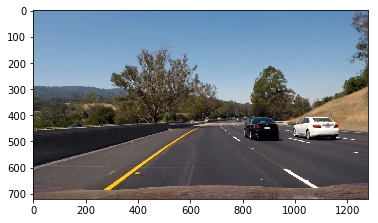

In [53]:
img = plt.imread('test_images/detection_testing/frame_38.png')
plt.imshow(img)

In [62]:
### FIND CARS PARAMETERS ###

#ystart = 400
#ystop = 656
#scale = 1.5
#scales = [1.5]
# scales dict :: scale: (ystart, ystop, cells_per_step)
scales_dict = {
    1: (400, 464, 1),
    1.5: (400, 528, 2),
    2: (400, 656, 2)
}


spatial_size = (32, 32)
hist_bins=32
hist_range=(0, 256)
orient=12
pix_per_cell=8
cell_per_block=2

scaler = load_clf('scaler_{}.pickle'.format(color_map))
clf = load_clf('{}_{}.pickle'.format(clf_type, color_map))

In [63]:
#out_img = find_cars(img, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(out_img)

In [64]:
windows_hat = []
for scale in scales_dict.keys():
    ystart = scales_dict[scale][0]
    ystop = scales_dict[scale][1]
    cells_per_step = scales_dict[scale][2]
    windows_hat_i = find_windows(img, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins)
    for i in windows_hat_i:
        windows_hat.append(i)


100%|██████████| 36/36 [00:02<00:00, 15.04it/s]


In [65]:
windows_hat

[((792, 400), (888, 496)),
 ((816, 400), (912, 496)),
 ((840, 400), (936, 496)),
 ((864, 400), (960, 496)),
 ((984, 400), (1080, 496)),
 ((736, 400), (864, 528)),
 ((768, 432), (896, 560)),
 ((800, 400), (928, 528)),
 ((800, 432), (928, 560)),
 ((832, 400), (960, 528)),
 ((1024, 400), (1152, 528))]

In [66]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def expand_labeled_bboxes(labels, windows_hat):
    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        print(nonzero)
        return nonzero

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        print(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img


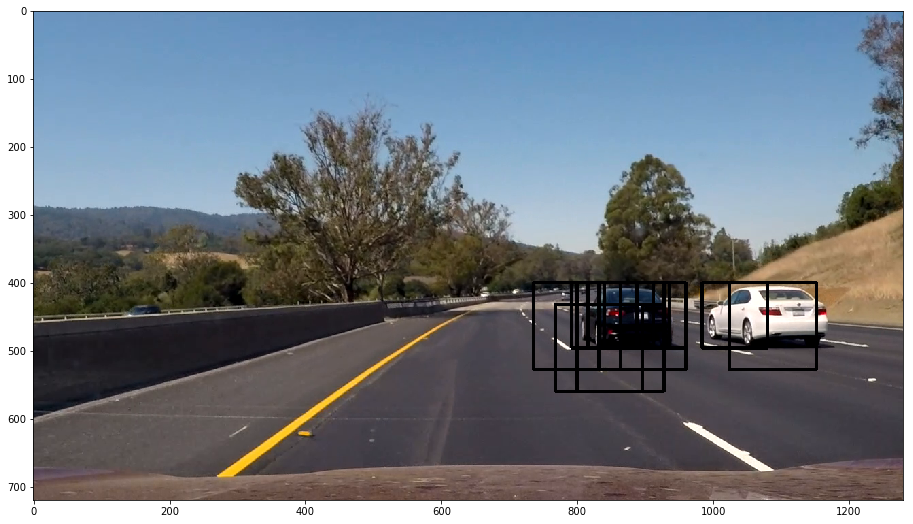

In [67]:
draw_img = draw_boxes(img, windows_hat)
fig, ax = plt.subplots(1, 1, figsize = (16,9))
ax.imshow(draw_img)

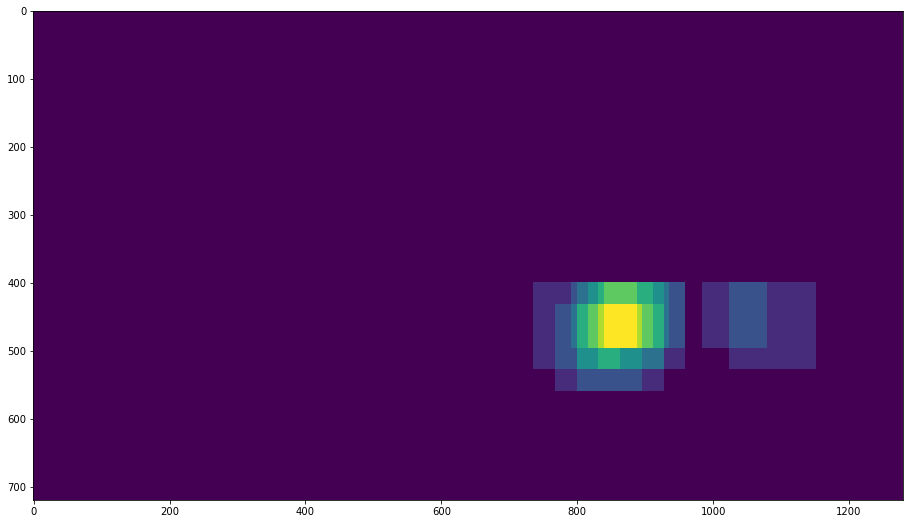

In [68]:
heatmap = np.zeros(img.shape[:2])
heatmap = add_heat(heatmap, windows_hat)


fig, ax = plt.subplots(1,1, figsize = (16, 9))
ax.imshow(heatmap)

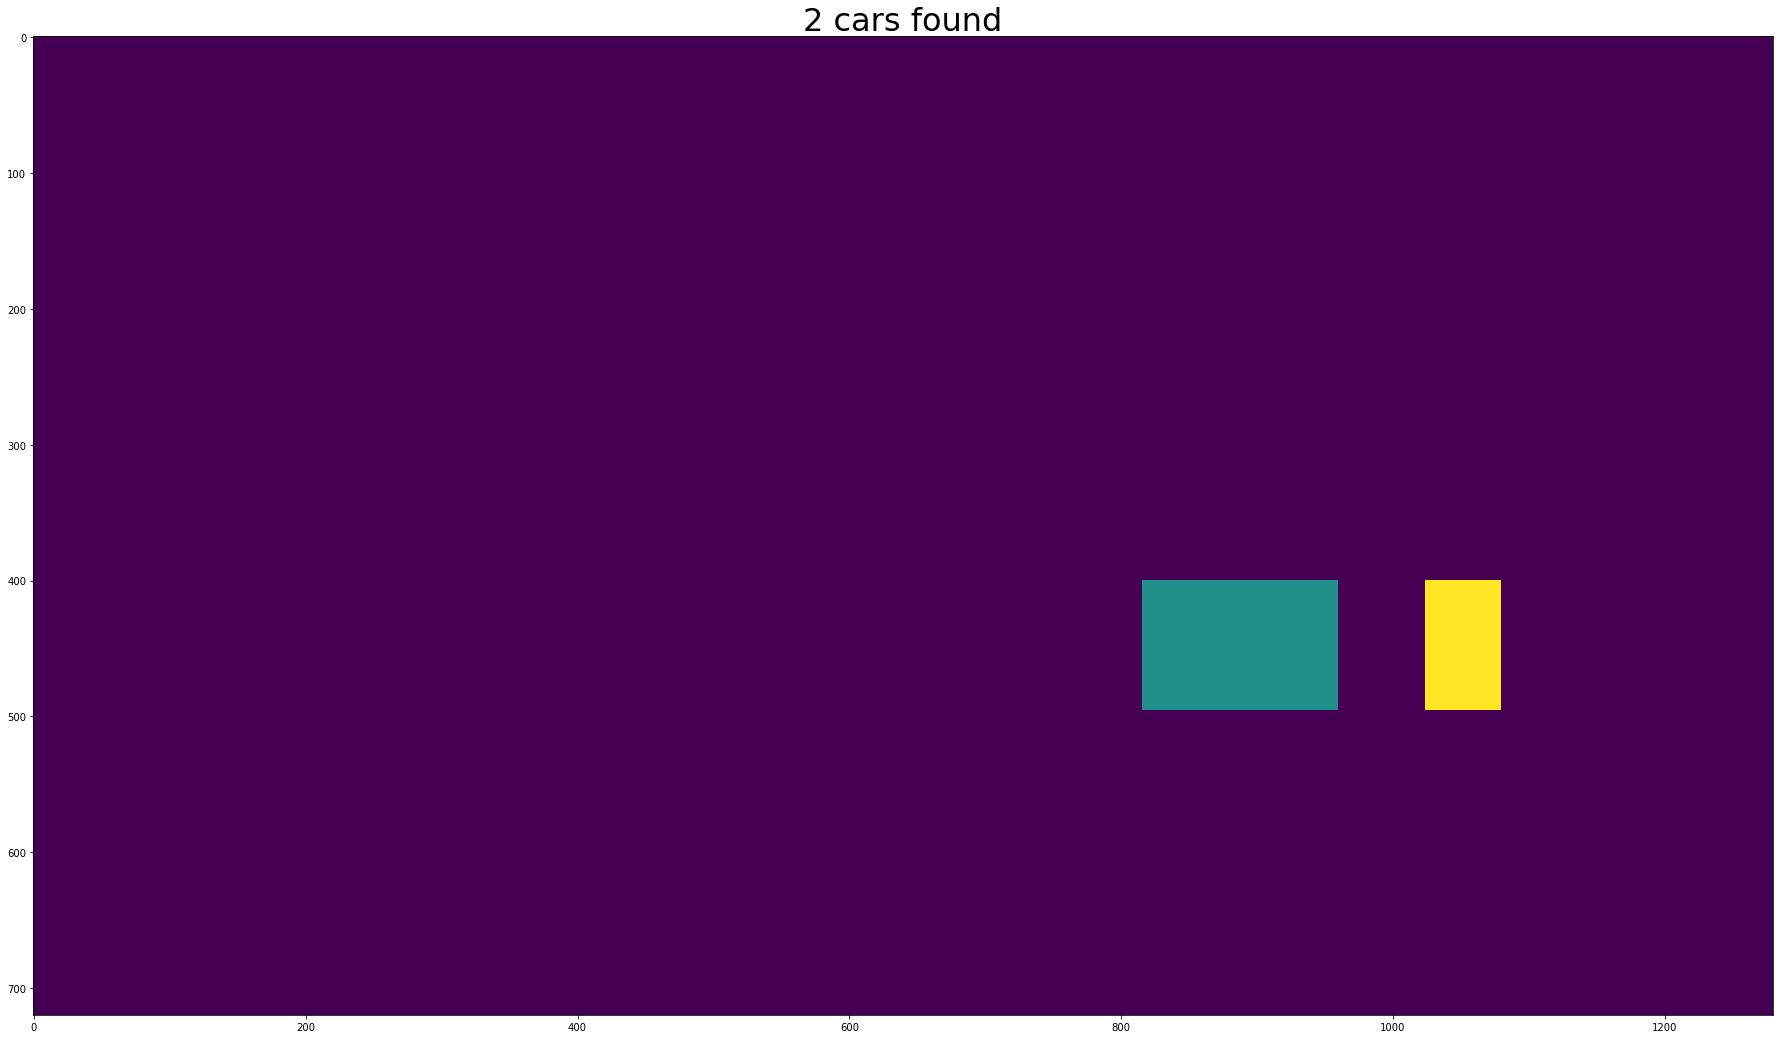

In [61]:
heat_thresh = 2

heatmap_thresh = apply_threshold(heatmap, threshold = heat_thresh)

labels = label(heatmap_thresh)

fig, ax = plt.subplots(1,1,figsize = (32,18))
ax.set_title('{} cars found'.format(labels[1]), fontsize = 32)
ax.imshow(labels[0])

((768, 400), (959, 559))
((1024, 400), (1079, 495))


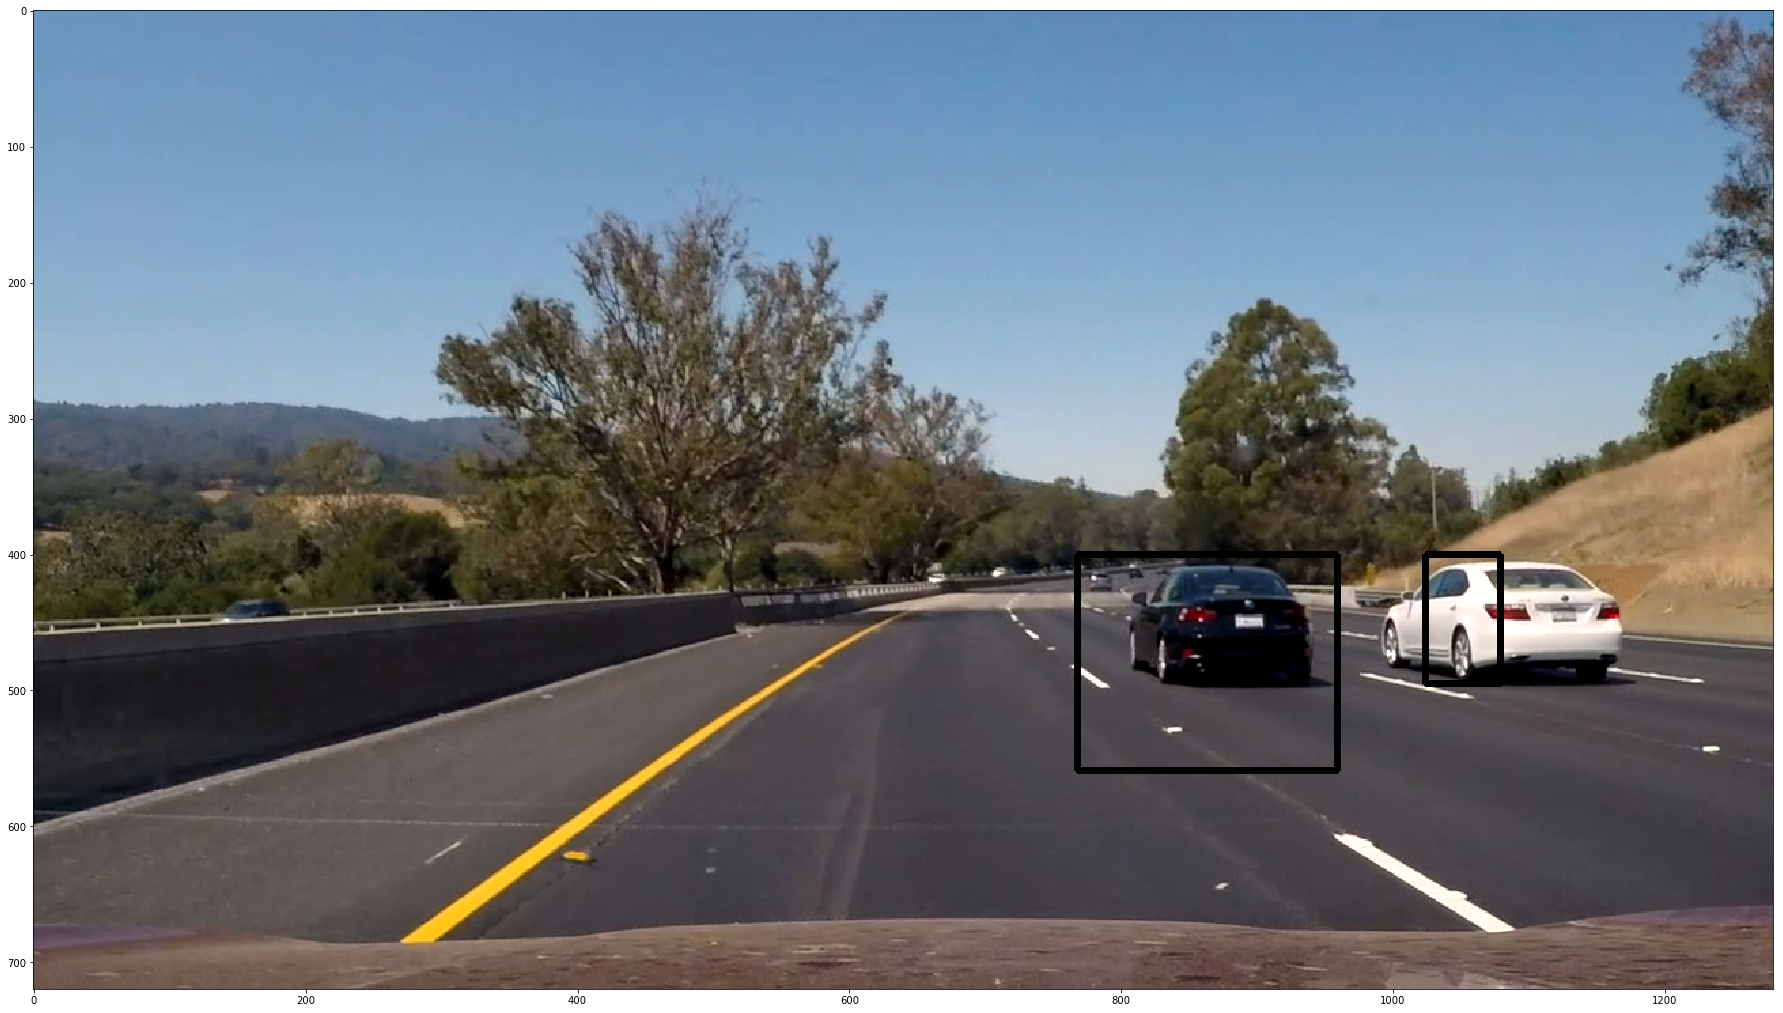

In [47]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig, ax = plt.subplots(1,1,figsize = (32,18))
ax.imshow(draw_img)